# 0. Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

In [5]:
from sklearn.metrics import average_precision_score

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [7]:
from sklearn.metrics import f1_score,make_scorer
scored=make_scorer(f1_score)

# 1. Data I/O

In [8]:
data=pd.read_csv('df_impfeatures_withid.csv')
data.head()

,001_IPF_0,001_IPF_1,001_IPF_2,100_IPF_0,100_IPF_1,100_IPF_2,111_IPF_0,111_IPF_1,111_IPF_2,AspectRatios_0,...,Omega3s,QPEuc,Schmid,SurfaceAreaVolumeRatio,SurfaceFeatures,TJEuc,hotspot,fileID,file_source,mPrimeList
0,0.314819,0.427569,0.274501,0.214385,0.460550,0.372547,0.255733,0.607882,0.669000,0.821072,...,0.801818,0.766849,0.459804,3.897135,0.0,0.423802,False,1,1,0.588892
1,0.216026,0.467399,0.384040,0.542158,0.444626,0.125266,0.060509,0.545659,0.526708,0.896180,...,0.715912,0.727803,0.497166,3.968258,0.0,0.431682,False,1,1,0.129135
2,0.117264,0.510865,0.470377,0.248346,0.467535,0.376097,0.441562,0.429924,0.196210,0.808131,...,0.861303,0.766598,0.478242,3.163448,0.0,0.497570,False,1,1,0.010403
3,0.039997,0.558397,0.546043,0.526644,0.429348,0.060637,0.427246,0.507653,0.383033,0.592307,...,0.000004,0.823149,0.455669,3.661804,1.0,0.465144,False,1,1,0.161447
4,0.463466,0.426146,0.160350,0.409262,0.415742,0.181440,0.178657,0.484543,0.420328,0.908052,...,0.824643,0.781541,0.450828,3.237414,0.0,0.495204,False,1,1,0.045107


# 2. Data Exploration

In [9]:
#data.info()

In [10]:
data.fillna(0,inplace=True)
data.hotspot.replace(False, 0 , inplace=True)
data.hotspot.replace(True, 1 , inplace=True)

In [11]:
data['hotspot'].value_counts() # Skewed data

0.0    166643
1.0     18534
Name: hotspot, dtype: int64

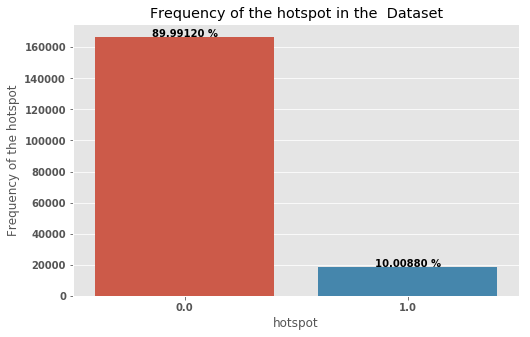

In [13]:
import matplotlib.style as style
style.use('ggplot')
plt.figure(figsize=(8,5))
ax=sns.countplot(x='hotspot', data=data);
total=float(len(data))
plt.title('Frequency of the hotspot in the  Dataset')
plt.ylabel('Frequency of the hotspot')
plt.xlabel('hotspot')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")

# 3. Data preprocessing

In [16]:
df_raw=data

In [17]:
t1=df_raw.loc[df_raw['file_source'] == 1]
t2=df_raw.loc[df_raw['file_source'] == 2]
t3=df_raw.loc[df_raw['file_source'] == 3]
t4=df_raw.loc[df_raw['file_source'] == 4]
t5=df_raw.loc[df_raw['file_source'] == 5]
t6=df_raw.loc[df_raw['file_source'] == 6]

In [18]:
dataframe=[t1,t2,t3,t4,t5,t6]

# 4. Utility Functions

In [19]:
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'16'}

In [20]:
def data_prep(df,t,m):
    
    df_temp=data
    list=dataframe[t].index[dataframe[t]['fileID']  == m].tolist()
    #df_temp.drop(list,inplace=True)
    X_train=df_temp.drop(list).drop(columns='hotspot')
    X_test=dataframe[t].loc[dataframe[t]['fileID'] == m].drop(columns='hotspot') 
    Y_train = df_temp.drop(list).hotspot
    Y_test= dataframe[t].loc[dataframe[t]['fileID'] == m].hotspot
    
    return(X_train,Y_train,X_test,Y_test)

In [21]:
import itertools

def plot_confusion_matrix(axd,cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.sca(axd)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1#print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=16)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
def model_fitting_and_post_processing(clf,X_train,Y_train,X_test,Y_test,clf_name='SVM',class_names=[0,1],cross_val=False):
    #average precision for the precision recall curves
    # passing dataframes into the function
    clf.fit(X_train.values,Y_train.values.ravel())
    #print(clf.best_estimator_)
    if cross_val:
        clf=clf.best_estimator_
        print('\n')
        print(clf)
        print('\n')
    predictions=clf.predict(X_test.values)
    #decision function
    try:
        Y_score = clf.decision_function(X_test.values)
    except:
        Y_score = clf.predict_proba(X_test.values)[:,1]
    #Y_score=clf.decision_function(X_test.values)
    # printing the accuracy
    print('The accruacy of %s on the Test set: '%clf_name, accuracy_score(Y_test.values,predictions))
    # predicting probabilities
    post_probab_predictions=clf.predict_proba(X_test.values)
    # assiging the probability
    post_probab_predictions=post_probab_predictions[:,1]
    # now subplotting
    fig, axes=plt.subplots(2,2,figsize=(14,10))
    # Class Distribution
    plt.sca(axes[0,0])
    data_train=X_train.copy()
    data_train['hotspot']=Y_train.values
    data_train['hotspot']=data_train['hotspot'].map({1.0:'hotspot',0.0:'coldspot'})
    ax=sns.countplot(x='hotspot', data=data_train);
    total=float(len(data_train))
    plt.title('Frequency of the target class in the Training-set',**title_font)
    plt.ylabel('Frequency of the target',**axis_font)
    plt.xlabel('Target Class',**axis_font)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.5f} %'.format(height*100/total),ha="center")
        #ax.text(p.get_x()+p.get_width()/2.,height - 35,'{:1.5f} '.format(height),ha="center")
    
    # Confusion Matrix
    cnf_matrix = confusion_matrix(Y_test.values,predictions)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(axes[0,1],cnf_matrix, classes=class_names, title='Confusion matrix')
    axes[0,1].grid('off')

    # ROC CURVE
    fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(),post_probab_predictions.ravel())
    roc_auc = auc(fpr,tpr)
    plt.style.use('ggplot')
    title_gp='ROC for '+clf_name+' Classifier'
    axes[1,0].set_title(title_gp)
    axes[1,0].plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    axes[1,0].legend(loc='lower right')
    axes[1,0].plot([0,1],[0,1],'r--')
    axes[1,0].set_ylabel('True Positive Rate',**axis_font)
    axes[1,0].set_xlabel('False Positive Rate',**axis_font)
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_score)
    average_precision = average_precision_score(Y_test.values.ravel(), Y_score)
    axes[1,1].step(recall, precision, color='red', alpha=0.2,where='post',label='Average Precision = %0.2f'%average_precision)
    axes[1,1].fill_between(recall, precision, step='post', alpha=0.2,color='b')
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_xlabel('Recall',**axis_font)
    axes[1,1].set_ylabel('Precision',**axis_font)
    title_gp='Precision-Recall Curve for '+clf_name+' Classifier'
    axes[1,1].set_title(title_gp)


    fig.tight_layout()
    print('\n')
    print('----------------------- Complete Classification Report -----------------------\n')
    print(classification_report(Y_test.values,predictions))
    print('\n')
    print('--------------------------- Post-processed Plots --------------------------\n')    
    return (predictions,post_probab_predictions)

In [23]:
def feature_engineering(data):
    X=data.drop(['fileID','file_source','hotspot'],axis=1)
    Y=data[['hotspot']]

    
    X_feat_train,X_feat_test,Y_feat_train,Y_feat_test = train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y.hotspot)
    
    X_feat_train.reset_index(inplace=True)
    X_feat_train.drop('index',axis=1,inplace=True)
    Y_feat_train.reset_index(inplace=True)
    Y_feat_train.drop('index',axis=1,inplace=True)
    X_feat_test.reset_index(inplace=True)
    X_feat_test.drop('index',axis=1,inplace=True)
    Y_feat_test.reset_index(inplace=True)
    Y_feat_test.drop('index',axis=1,inplace=True)

    return(X_feat_train,Y_feat_train,X_feat_test,Y_feat_test)

In [24]:
def sample_prep(data):
    X_rtrain=data_resampled.drop(['hotspot'],axis=1)
    Y_rtrain=data_resampled[['hotspot']]
    xcols=X_rtrain.columns.tolist()
    X_rtrain=StandardScaler().fit_transform(X_rtrain)
    X_rtrain=pd.DataFrame(X_rtrain,columns=xcols)
    
    return (X_rtrain,Y_rtrain)

# 5. Model Building

## 5.1 Logisitic regression (benchmark)

In [ ]:
clf_log=LogisticRegression()
X_train,Y_train,X_test,Y_test=data_prep(data)
pred_log1,pred_probab1=model_fitting_and_post_processing(clf_log,X_train,Y_train,X_test,Y_test,clf_name='Logistic Reg',class_names=['coldspot','hotspot'])

## 5.2 Logisitic regression with ADASYN (benchmark)

In [ ]:
X_train,Y_train,X_test,Y_test=data_prep(data)

os_ada=ADASYN(random_state=0)
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['hotspot']=Y_oversampled
X_rtrain,Y_rtrain=sample_prep(data_resampled)

In [ ]:
pred_log2,pred_probab2=model_fitting_and_post_processing(clf_log,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Logistic Reg + ADASYN',class_names=['coldspot','hotspot'])

## 5.3 Logisitic regression with Under Sampling(benchmark)

In [ ]:
X_train,Y_train,X_test,Y_test=data_prep(data)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
xcols=X_train.columns.tolist()
X_undersampled,Y_undersampled=rus.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_undersampled,columns=xcols)
data_resampled['hotspot']=Y_undersampled
X_utrain,Y_utrain=sample_prep(data_resampled)

In [ ]:
pred_log3,pred_probab3=model_fitting_and_post_processing(clf_log,X_utrain,Y_utrain,X_test,Y_test,clf_name='Logistic Reg + Rand Under',class_names=['coldspot','hotspot'])

In [ ]:
#X_utrain,Y_utrain=sample_prep(data_resampled)

## 5.4 Random Forests + No CV

The accruacy of Random Forests on the Test set:  0.6998641040574646


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81      4635
         1.0       0.19      0.63      0.30       516

   micro avg       0.70      0.70      0.70      5151
   macro avg       0.57      0.67      0.55      5151
weighted avg       0.87      0.70      0.76      5151



--------------------------- Post-processed Plots --------------------------



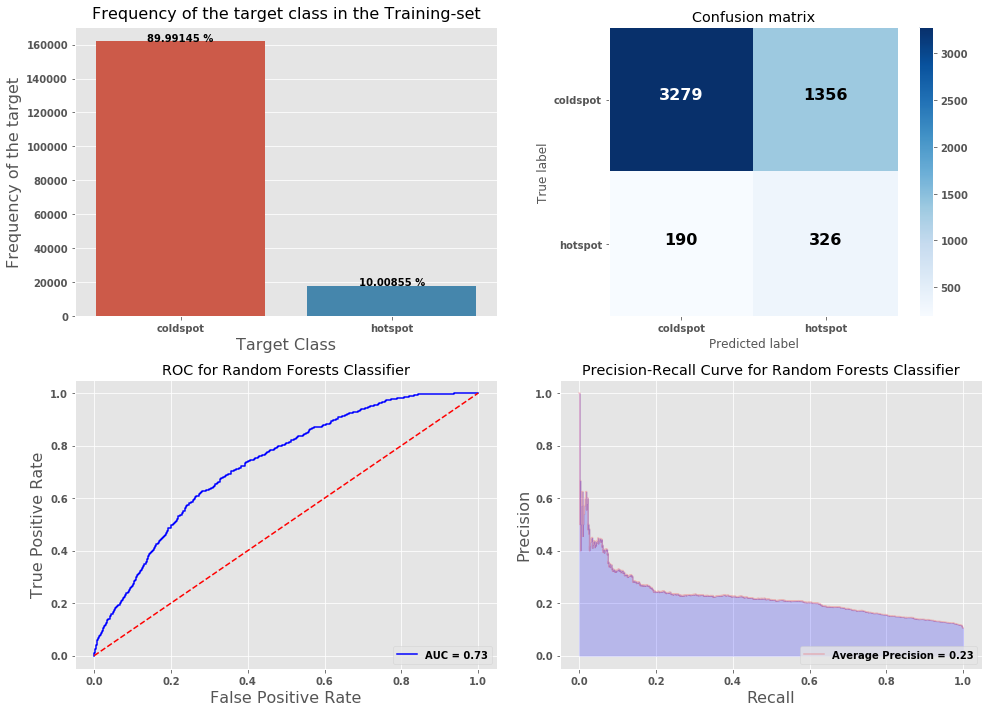

In [26]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0,class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,4,1)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.8423091824874079


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      4645
         1.0       0.27      0.34      0.30       517

   micro avg       0.84      0.84      0.84      5162
   macro avg       0.60      0.62      0.61      5162
weighted avg       0.86      0.84      0.85      5162



--------------------------- Post-processed Plots --------------------------



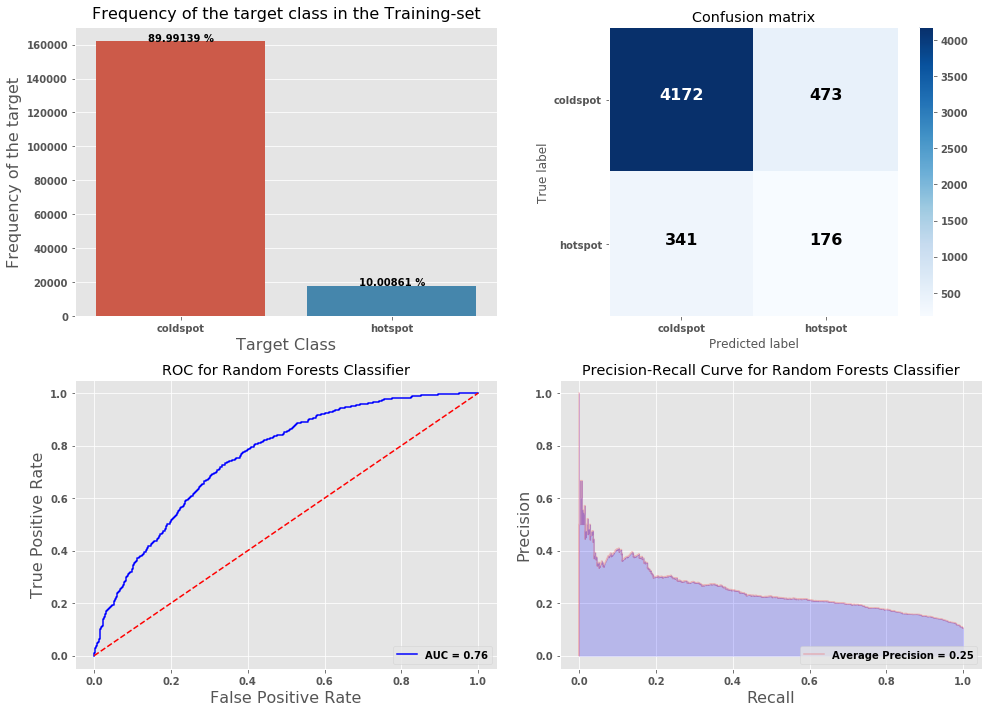

In [27]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0,class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,4,2)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.7903726708074534


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      4636
         1.0       0.25      0.53      0.34       516

   micro avg       0.79      0.79      0.79      5152
   macro avg       0.59      0.68      0.61      5152
weighted avg       0.87      0.79      0.82      5152



--------------------------- Post-processed Plots --------------------------



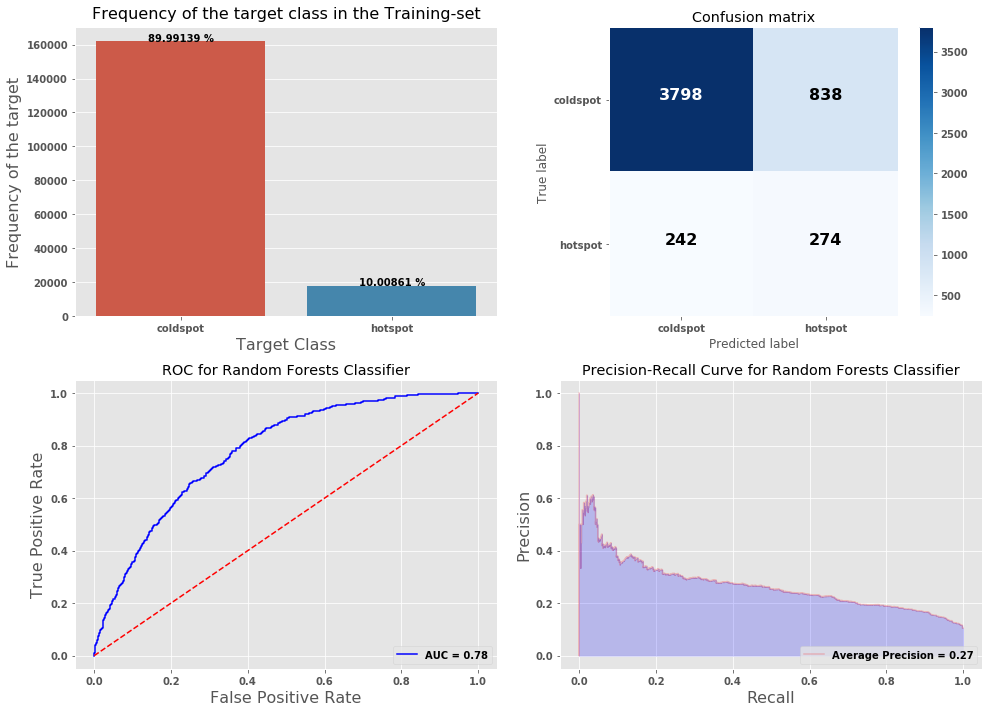

In [28]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0,class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,4,3)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.766287284144427


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86      4586
         1.0       0.23      0.58      0.33       510

   micro avg       0.77      0.77      0.77      5096
   macro avg       0.59      0.69      0.60      5096
weighted avg       0.87      0.77      0.81      5096



--------------------------- Post-processed Plots --------------------------



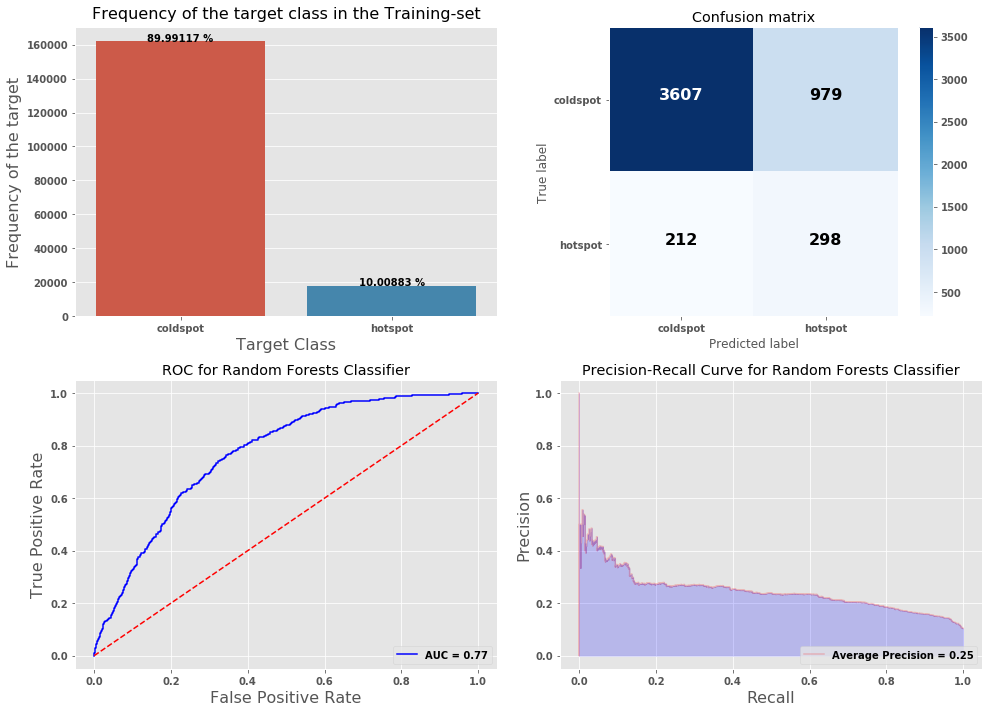

In [29]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0,class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,4,4)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.7244522008919915


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83      4641
         1.0       0.21      0.62      0.31       516

   micro avg       0.72      0.72      0.72      5157
   macro avg       0.58      0.68      0.57      5157
weighted avg       0.87      0.72      0.78      5157



--------------------------- Post-processed Plots --------------------------



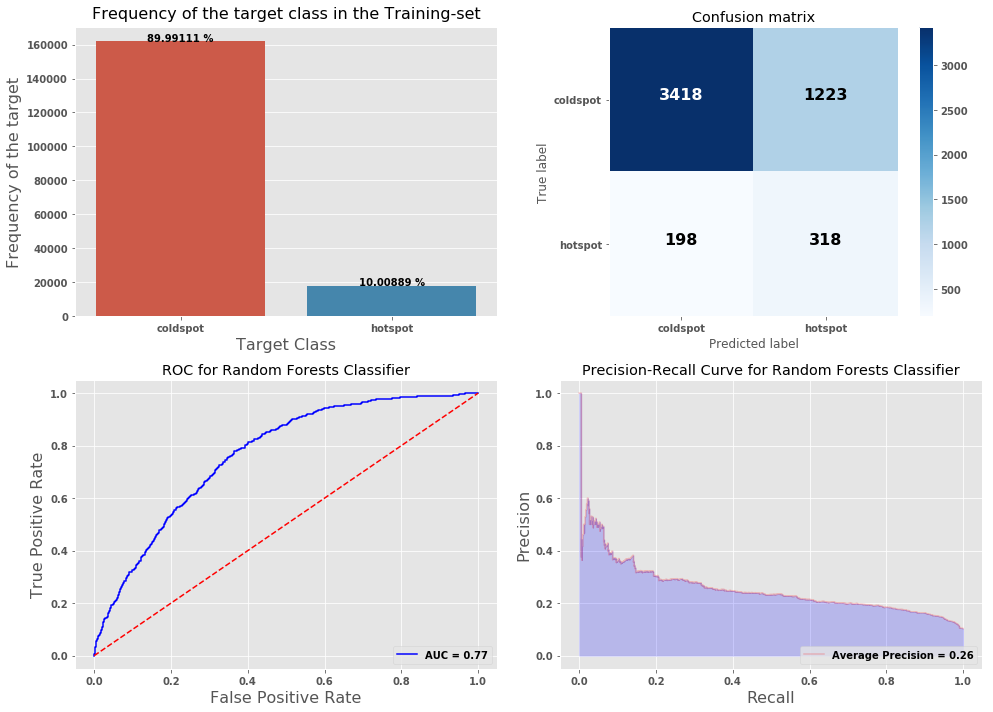

In [30]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0,class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,4,5)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

The accruacy of Random Forests on the Test set:  0.7016757599376462


----------------------- Complete Classification Report -----------------------

              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81      4618
         1.0       0.20      0.67      0.31       514

   micro avg       0.70      0.70      0.70      5132
   macro avg       0.58      0.69      0.56      5132
weighted avg       0.88      0.70      0.76      5132



--------------------------- Post-processed Plots --------------------------



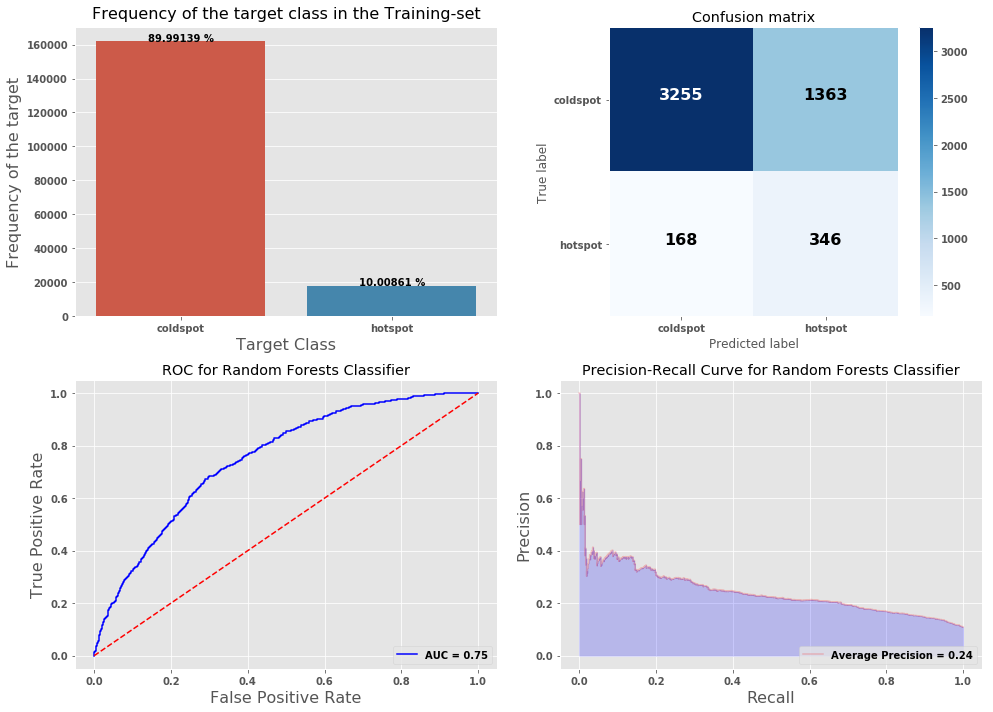

In [31]:
clf_rf=RandomForestClassifier(n_estimators=1200,max_depth=8,n_jobs=8,random_state=0,class_weight={0:1,1:9})
X_train,Y_train,X_test,Y_test=data_prep(data,4,6)
preds_rf1,probab_rf1=model_fitting_and_post_processing(clf_rf,X_train,Y_train,X_test,Y_test,clf_name='Random Forests',class_names=['coldspot','hotspot'])

## 5.5 Random Forests + ADASYN

In [ ]:
preds_rf2,probab_rf2=model_fitting_and_post_processing(clf_rf,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='Random Forests + ADASYN',class_names=['coldspot','hotspot'])

## 5.6 Random Forests + Random Under Sampling

In [ ]:
clf_rf=RandomForestClassifier(n_estimators=200,max_depth=10,n_jobs=8,random_state=0)
preds_rf3,probab_rf3=model_fitting_and_post_processing(clf_rf,X_utrain,Y_utrain,X_test,Y_test,clf_name='Random Forests + Rand under sampling',class_names=['coldspot','hotspot'])

## 5.10 XGBoost 

In [ ]:
clf_xgbc=xgb.XGBClassifier(n_estimators=200,max_depth=5,random_state=0,n_jobs=-1)
X_train,Y_train,X_test,Y_test=data_prep(data)
xgb_preds1,xgb_probab1=model_fitting_and_post_processing(clf_xgbc,X_train,Y_train,X_test,Y_test,clf_name='XGBoost',class_names=['coldspot','hotspot'])

## 5.11 XGBoost + ADASYN

In [ ]:
X_train,Y_train,X_test,Y_test=data_prep(data)
xcols=X_train.columns.tolist()
X_oversampled,Y_oversampled=os_ada.fit_sample(X_train,Y_train.values.ravel())
data_resampled=pd.DataFrame(X_oversampled,columns=xcols)
data_resampled['hotspot']=Y_oversampled
X_rtrain,Y_rtrain=sample_prep(data_resampled)

In [ ]:
xgb_pred2,xgb_probab2=model_fitting_and_post_processing(clf_xgbc,X_rtrain,Y_rtrain,X_test,Y_test,clf_name='XGBoost with ADASYN',class_names=['coldspot','hotspot'])

## 5.12 XGBoost + Rand Under sampling

In [ ]:
xgb_preds4,xgb_probab4=model_fitting_and_post_processing(rfrscv,X_utrain,Y_utrain,X_test,Y_test,clf_name='XGBoost with CV + RUS',class_names=['coldspot','hotspot'],cross_val=True)